# Import 

In [1]:
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from PIL import Image

from tensorboardX import SummaryWriter

import sys
from d2l import torch as d2l

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Augment

In [2]:
def show_images(imgs, num_cols, scale=2):
    figsize = (num_cols * scale, scale)
    _, axes = d2l.plt.subplots(1, num_cols, figsize=figsize)
    for j in range(num_cols):
        axes[j].imshow(imgs[j])
        axes[j].axes.get_xaxis().set_visible(False)
        axes[j].axes.get_yaxis().set_visible(False)
    return axes

def apply(img, aug, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_cols)]
    show_images(Y, num_cols, scale)

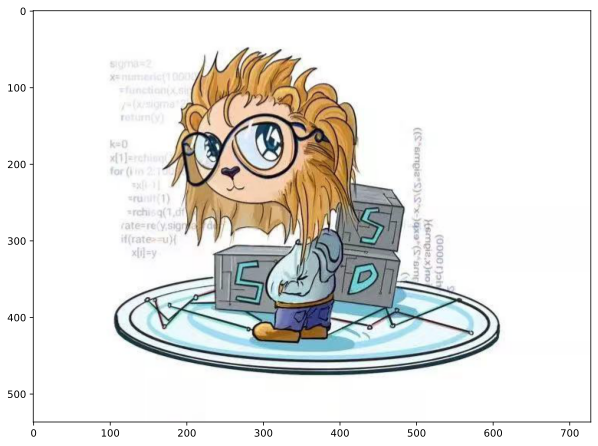

In [3]:
d2l.set_figsize((10,10))
img = Image.open("./img/子彬狮.jpg")
d2l.plt.imshow(img)

## 水平翻转

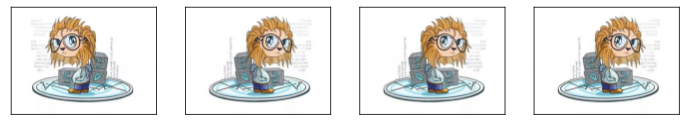

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

## 垂直翻转

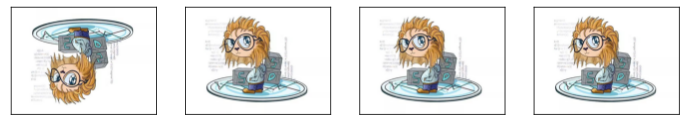

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

### 随机裁剪出一块面积为原面积 60% $\sim$ 100% 的区域，且该区域的宽和高之比随机取自 0.5 $\sim$ 2，然后再将该区域的宽和高分别缩放到原像素。

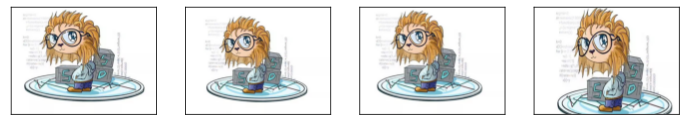

In [6]:
cropping_aug = torchvision.transforms.RandomResizedCrop(size=(img.size[1],img.size[0]), scale=(0.6, 1), ratio=(0.5, 2))
apply(img, cropping_aug)

## 颜色变化

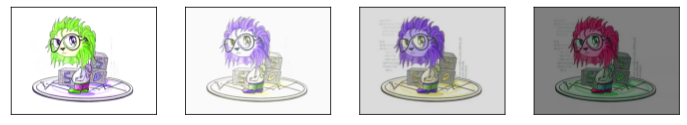

In [7]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

## 组合（水平翻转+剪裁）

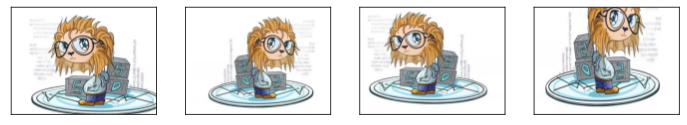

In [8]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), cropping_aug])
apply(img, augs)

# cifar10 data

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

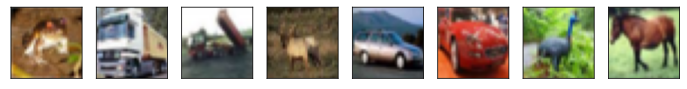

In [9]:
imgs = trainset = torchvision.datasets.CIFAR10(root = "", train = True,download = False)
show_images([imgs[i][0] for i in range(32)], 8, scale=1.5)

# Train model

## Resnet

In [10]:

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            # 残差块的第一个卷积
            # 通道数变换in->out，每一层（除第一层外）的第一个block
            # 图片尺寸变换：stride=2时，w-3+2 / 2 + 1 = w/2，w/2 * w/2
            # stride=1时尺寸不变，w-3+2 / 1 + 1 = w
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            # 残差块的第二个卷积
            # 通道数、图片尺寸均不变
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        
        # 残差块的shortcut
        # 如果残差块的输入输出通道数不同或步长不同，则需要变换通道数及图片尺寸，以和residual部分相加
        # 输出：通道数*2 图片尺寸/2
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():
    return ResNet(ResidualBlock)


## Augment policy

In [11]:
# 水平翻转
horiFlip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

# 垂直翻转
vertFlip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomVerticalFlip(),
     torchvision.transforms.ToTensor()])

# 形状剪裁和缩放
cropping_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomResizedCrop(size=(32,32), scale=(0.6, 1), ratio=(0.5, 2)),
     torchvision.transforms.ToTensor()])

# 变化颜色
coloring_aug = torchvision.transforms.Compose([
     torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
     torchvision.transforms.ToTensor()])
 
# 组合
composite_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop(size=(32,32), scale=(0.6, 1), ratio=(0.5, 2)),
    torchvision.transforms.ToTensor()])
    
# 无
no_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

## Train

In [12]:
#calculate accuracy on testloader or trainloader
def test(net,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for image,labels in testloader:
            image, labels = Variable(image.cuda()), Variable(labels.cuda())
            outputs = net(image)
            _,predict = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()
    return 100*correct/total

def load_cifar10(is_train, augs, batch_size, root=""):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=False)
    return DataLoader(dataset, batch_size=batch_size)

def train(augs, aug_name, batch_size, lr = 0.001, epoch_times = 30):
    
    trainset = load_cifar10(True, augs, batch_size)
    
    performance_path = 'performance/' + aug_name
    print(f'write path = {performance_path}')
    writer = SummaryWriter(performance_path)
    
    loss = nn.CrossEntropyLoss()
    net = ResNet18()
    net.cuda()
    optimizer = optim.Adam(net.parameters(),lr = lr)
        
    for epoch in range(epoch_times):
        
        timestart = time.time()
        
        for X, y in trainset:
            
            X, y = Variable(X.cuda()), Variable(y.cuda())
            #更新参数时把梯度转到optimizer上
            optimizer.zero_grad() 
            output = net(X) 
            l = loss(output,y)
            #计算loss后计算梯度
            l.backward() 
            #更新参数
            optimizer.step() 

        #calcuate accuracy and loss on training and test set per epoch
        with torch.no_grad():
            train_accuracy = test(net, trainset)
            test_accuracy = test(net, testset)
        writer.add_scalar('training_loss', l, global_step = epoch)
        writer.add_scalar('training_accuracy', train_accuracy, global_step = epoch)
        writer.add_scalar('test_accuracy', test_accuracy, global_step = epoch)

        print(f'\t epoch = {epoch}, time = {round(time.time()-timestart, 2)}sec')
        print(f'\t\t training_loss = {l},')
        print(f'\t\t training_accuracy = {train_accuracy}%')
        print(f'\t\t test_accuracy = {test_accuracy}%')
    
    print('finish and writer closed')
    writer.close()
    model_path = f'model/{aug_name}.pt'
    torch.save(net, model_path)
    return {'policy':aug_name, 'training_accuracy':train_accuracy, 'test_accuracy':test_accuracy}

In [13]:
# 对测试数据不做处理
testset = load_cifar10(False, no_aug, 1000)

In [14]:
para_dict = {'no_aug': no_aug, 'horiFlip': horiFlip_aug, 'vertFlip': vertFlip_aug, 'cropping': cropping_aug, 'coloring': coloring_aug, 'composite': composite_aug}
accuracies = []

In [15]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
for aug_name, aug in para_dict.items():
    torch.cuda.empty_cache()
    print(f'augment policy is {aug_name}')
    accuracies.append(train(aug, aug_name, 1000, epoch_times = 26))
    torch.cuda.empty_cache()

augment policy is no_aug
write path = performance/no_aug
	 epoch = 0, time = 27.1sec
		 training_loss = 1.4053096771240234,
		 training_accuracy = 48.668%
		 test_accuracy = 48.26%
	 epoch = 1, time = 24.31sec
		 training_loss = 1.0529537200927734,
		 training_accuracy = 62.82%
		 test_accuracy = 61.87%
	 epoch = 2, time = 24.46sec
		 training_loss = 0.8200923204421997,
		 training_accuracy = 71.47%
		 test_accuracy = 68.95%
	 epoch = 3, time = 24.51sec
		 training_loss = 0.6396316885948181,
		 training_accuracy = 78.198%
		 test_accuracy = 73.77%
	 epoch = 4, time = 24.54sec
		 training_loss = 0.4888536036014557,
		 training_accuracy = 81.202%
		 test_accuracy = 75.78%
	 epoch = 5, time = 24.6sec
		 training_loss = 0.41290539503097534,
		 training_accuracy = 84.816%
		 test_accuracy = 78.18%
	 epoch = 6, time = 24.62sec
		 training_loss = 0.32188427448272705,
		 training_accuracy = 87.022%
		 test_accuracy = 78.62%
	 epoch = 7, time = 24.62sec
		 training_loss = 0.2863784432411194,
		

## 保存结果

In [16]:
import pandas as pd
pd.DataFrame(accuracies).to_excel('output/accuracies.xlsx')